#### Training a neural network to estimate selection coefficients
#### Seth Temple, sdtemple.github.io
#### 11/14/2024

A decent amount of code is Copy + Paste and modify from: 

https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb


To do:
- Figure expressing uncertainty in selection coefficient estimation
- Train the neural network with a convolutional layer
- Train the neural networks on Great Lakes cluster

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from simple_selcoef import * # must be in same folder
plt.rc('font',size=14)

In [2]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS, activation):
        super().__init__()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [ ]:
class CNN():
    pass

In [ ]:
def bootstrap(num_rep: int,
              s_start: float,
              s_step: float,
              s_end: float,
              p_start: float,
              p_step: float,
              p_end : floar,
              gens: list,
              sizes: list
              ):
    ss = np.arange(s_start,s_end,s_step)
    N = num_rep
    ps = np.arange(p_start,p_end,p_step)
    M = N*len(ss)*len(ps)
    y_array = np.zeros((M,1),dtype=np.float32)
    x_array = np.zeros((M,gens.shape[0]),dtype=np.float32)
    j = 0
    for p in ps:
        for s in ss:
            for n in range(N):
                y = s
                x0, _, _ = walk_variant_backward(y,p,Ne,random_walk=True,one_step_model='m') # wright fisher process
                # address fixation of allele
                last_element = x0[-1] # Get the last element of the array
                extension = np.full(gens[-1], last_element) # Create an array of the same value
                extended_arr = np.append(x0, extension) # Extend the original array
                x = extended_arr[gens]
                x_sampled = np.random.binomial(sizes,x) / sizes
                x_array[j,:] = x_sampled
                y_array[j] = y
                j += 1
    x_data = torch.from_numpy(x_array)
    y_data = torch.from_numpy(y_array)
    return x_data, y_data

In [ ]:
def bootstrap_interval(model,
                       nboot: int,
                       prediction: float,
                       p: float,
                       Ne: dict,
                       gens: list,
                       sizes: list,
                       qlow=0.025,
                       qupp=0.975,
                       ) -> list:
    x_data, _ = bootstrap(nboot,
                          prediction,
                          0.011,
                          prediction+0.01,
                          p,
                          0.11,
                          p+0.1,
                          gens,
                          sizes,
                          )
    y_boot = model(x_data)
    y_boot = y_boot.cpu().detach().numpy()
    ylow = np.quantile(y_boot, qlow)
    yupp = np.quantile(y_boot, qupp)
    return ylow, yupp

In [ ]:
def sweep(s: float,p: float,Ne: dict,gens: list):
    x0, _, _ = walk_variant_backward(s,p,Ne,random_walk=False,one_step_model='m') # wright fisher process
    # address fixation of allele
    last_element = x0[-1] # Get the last element of the array
    extension = np.full(gens[-1], last_element) # Create an array of the same value
    extended_arr = np.append(x0, extension) # Extend the original array
    x = extended_arr[gens]
    return x[1:]

In [ ]:
def plot_scatter_pred(predicted, actual, downsample_prop=1.):
    # Convert tensors to numpy arrays
    predicted_np = predicted.cpu().detach().numpy()
    actual_np = actual.cpu().detach().numpy()
    nrows = predicted.shape[0]
    nkeep = int(nrows*downsample_prop)
    sampled_indices = np.random.choice(nrows,nkeep,replace=False)
    predicted_np_down = predicted_np[sampled_indices]
    actual_np_down = actual_np[sampled_indices]

    # Plot the data
    plt.scatter(actual_np_down, predicted_np_down, alpha=0.5)
    plt.plot([actual_np.min(), actual_np.max()], [actual_np.min(), actual_np.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual values')
    plt.ylabel('Predicted values')
    plt.grid(alpha=0.25)
    plt.legend()
    plt.show()

#### Simulating data

In [ ]:
### Population genetics parameters

# Simulation data
sample_size = 50
num_rep = 5
s_start = -0.1
s_step = 0.002 # step size for selection coefficient
s_end = 0.1 # numbers of steps for selection coefficient
p_start = 0.1 # starting frequency in loop
p_step = 0.025 # step size for frequency
p_end = 0.9 # number of steps for frequency
gens = np.arange(0,50,5)
sizes = np.repeat(sample_size, gens.shape[0])

# Make an Ne file
make_constant_Ne('c10.ne',1e4, 500)
Ne = read_Ne('c10.ne')

### Neural networks parameters

num_epochs = 20
num_batches = 10
num_hidden = 32
num_layers = 3
act = nn.Tanh


In [53]:

x_data, y_data = bootstrap(num_rep,
                           s_start,
                           s_step,
                           s_end,
                           p_start,
                           p_step,
                           p_end,
                           gens,
                           sizes)


In [ ]:
# rename data files if applicable
torch.save(x_data,'x_train.pth')
torch.save(y_data,'y_train.pth')

#### Training the model

In [ ]:
# rename data files if applicable
x_data = torch.load('x_train.pth')
y_data = torch.load('y_train.pth')

/tmp/ipykernel_1137/911315186.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_data = torch.load('x_train.pth')
/tmp/ipykernel_1137/911315186.py:2: FutureWarning: You a

In [ ]:
# Train standard neural network to fit training data
dataset = TensorDataset(x_data,y_data)
dataloader = DataLoader(dataset, batch_size=num_batches, shuffle=True)
torch.manual_seed(123)
fcn_model = FCN(gens.shape[0],1,num_hidden,num_layers,act)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
files = []
for i in range(num_epochs):
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        yh = fcn_model(inputs)
        loss = torch.mean((yh-targets)**2)# use mean squared error
        loss.backward()
        optimizer.step()
            

In [ ]:
# Train a neural network with a convolutional layer
# cnn_model

In [ ]:
# Save the standard model
torch.save(fcn_model, 'fcn-model.pth')

In [ ]:
# Save the convolutional model
# torch.save(cnn_model, 'cnn-model.pth')

#### Model evaluation

In [ ]:
# load in data and model
# predict on testing data
x_test = torch.load('x_test.pth')
y_test = torch.load('y_test.pth')
saved_model = torch.load('model.pth')
y_pred = saved_model(x_test)

/tmp/ipykernel_1137/3302899632.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  x_test = torch.load('x_test.pth')
/tmp/ipykernel_1137/3302899632.py:2: FutureWarning: You 

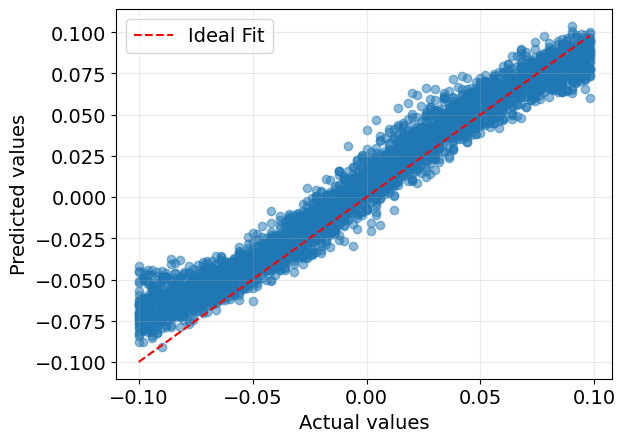

In [151]:
plot_scatter_pred(y_pred,y_test,1.)

In [ ]:
# compute a bootstrap interval
# mainly expresses wright-fisher uncertainty
l,u=bootstrap_interval(saved_model,1,0.0,0.20,Ne,gens,sizes)
u-l,u,l

(0.0, -0.006821360904723406, -0.006821360904723406)